In [1]:
# import some libraries
import os,sys
from scipy.stats import hmean
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

## Extract temperature data for MC-rejection
For this, we use the `borehole logs`function in shemat. Borehole logs are defined for `i` and `j` values:  
* 32, 15
* 79, 23
* 54, 35
* 50, 45

In [5]:
# i and j values need to be substracted by 1, as fortran starts to count at 1, and python at 0
bhole = np.array([[31, 14],
                 [78, 22],
                 [53, 34],
                 [49, 44]])

In [6]:
def load_borehole_log(datafile: str=None, z_asl: int=0):
    
    if z_asl > 0:
        z_asl = -z_asl
        
    header = ['temperature', 'hydraulic head', 'pressure', 'delz', 'uindex']
    
    data = np.loadtxt(datafile)
    log_file = pd.DataFrame(data=data, columns=header)
    log_file['z_asl'] = log_file['delz'].cumsum() + z_asl
    
    return log_file

def extractLogHDF(hdf_file: str=None, borehole_coordinate: list=[0,0], z_asl: int=0):
    
    if z_asl > 0:
        z_asl = -z_asl
        
    h5_file = h5py.File(hdf_file)
    log_data = {}
    log_data['temperature'] = h5_file['temp'][:, borehole_coordinate[1], borehole_coordinate[0]]
    log_data['hydraulic head'] = h5_file['head'][:, borehole_coordinate[1], borehole_coordinate[0]]
    log_data['pressure'] = h5_file['pres'][:, borehole_coordinate[1], borehole_coordinate[0]]
    log_data['uindex'] = h5_file['uindex'][:, borehole_coordinate[1], borehole_coordinate[0]]
    log_data['z_asl'] = h5_file['z'][:,0,0] + z_asl
    
    borehole_dataframe = pd.DataFrame.from_dict(log_data)
    
    return borehole_dataframe
    

In [11]:
h5_log = extractLogHDF('../models/20210319_MC_no_middle_filling/SHEMAT_PCT_base_model_temp_final.h5',
                       borehole_coordinate=bhole[0,:], z_asl=-6500)

In [12]:
h5_log

,temperature,hydraulic head,pressure,uindex,z_asl
0,234.200420,6878.434051,66.830584,12,-6437.5
1,230.043436,6890.726477,65.727134,12,-6312.5
2,225.908875,6902.609445,64.619676,12,-6187.5
3,221.796654,6914.092648,63.508303,12,-6062.5
4,217.706683,6925.185289,62.393107,12,-5937.5
5,213.638866,6935.896192,61.274173,12,-5812.5
6,209.593100,6946.233878,60.151585,12,-5687.5
7,205.569276,6956.206646,59.025425,12,-5562.5
8,201.567279,6965.822653,57.895772,12,-5437.5
9,197.586984,6975.089971,56.762705,12,-5312.5


In [13]:
h5_file = h5py.File('../models/20210319_MC_no_middle_filling/SHEMAT_PCT_base_model_temp_final.h5')

In [14]:
temps = h5_file['temp'][:,bhole[0,1], bhole[0,0]]

In [15]:
temp = h5_file['temp'][:,:,:]
head = h5_file['head'][:,:,:]
pres = h5_file['pres'][:,:,:]
uindex = h5_file['uindex'][:,:,:]



In [16]:
h5_file['z'][:,0,0]

array([  62.5,  187.5,  312.5,  437.5,  562.5,  687.5,  812.5,  937.5,
       1062.5, 1187.5, 1312.5, 1437.5, 1562.5, 1687.5, 1812.5, 1937.5,
       2062.5, 2187.5, 2312.5, 2437.5, 2562.5, 2687.5, 2812.5, 2937.5,
       3062.5, 3187.5, 3312.5, 3437.5, 3562.5, 3687.5, 3812.5, 3937.5,
       4062.5, 4187.5, 4312.5, 4437.5, 4562.5, 4687.5, 4812.5, 4937.5,
       5062.5, 5187.5, 5312.5, 5437.5, 5562.5, 5687.5, 5812.5, 5937.5,
       6062.5, 6187.5, 6312.5, 6437.5, 6562.5, 6687.5, 6812.5, 6937.5,
       7062.5, 7187.5, 7312.5, 7437.5])

In [17]:
log1 = load_borehole_log('../models/20210219_MC_ensemble/PCT_base_model_final_borehole3.dat', z_asl=-6500)

<AxesSubplot:xlabel='temperature', ylabel='z_asl'>

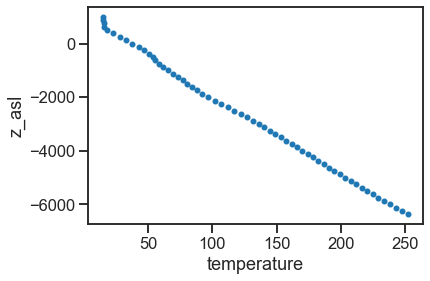

In [18]:
log1.plot.scatter('temperature', 'z_asl')

In [46]:
log1

,temperature,hydraulic head,pressure,delz,uindex,z_asl
0,263.835994,7098.739569,6.898746e+07,125.0,13.0,-6375.0
1,259.031686,7118.111336,6.795332e+07,125.0,13.0,-6250.0
2,254.239864,7136.922180,6.691369e+07,125.0,13.0,-6125.0
3,249.460874,7155.178945,6.586863e+07,125.0,13.0,-6000.0
4,244.694821,7172.888698,6.481822e+07,125.0,13.0,-5875.0
5,239.941686,7190.058724,6.376252e+07,125.0,13.0,-5750.0
6,235.201381,7206.696508,6.270161e+07,125.0,13.0,-5625.0
7,230.473742,7222.809730,6.163557e+07,125.0,13.0,-5500.0
8,225.758530,7238.406274,6.056447e+07,125.0,13.0,-5375.0
9,221.055429,7253.494234,5.948839e+07,125.0,13.0,-5250.0


In [47]:
data = pd.DataFrame(log1['temperature'][21:56])

In [48]:
data['i'] = 53
data['j'] = 34
data['k'] = data.index
data['error'] = 0.5
data['var_flag'] = 2
data['flag'] = 1
data['Name'] = "!borehole3"

In [49]:
data = data.reindex(columns= ['temperature', 'error', 'i', 'j', 'k', 'var_flag', 'flag', 'Name'])

In [50]:
data

,temperature,error,i,j,k,var_flag,flag,Name
21,165.168817,0.5,53,34,21,2,1,!borehole3
22,160.532261,0.5,53,34,22,2,1,!borehole3
23,155.951397,0.5,53,34,23,2,1,!borehole3
24,151.411795,0.5,53,34,24,2,1,!borehole3
25,146.878488,0.5,53,34,25,2,1,!borehole3
26,142.417330,0.5,53,34,26,2,1,!borehole3
27,138.149406,0.5,53,34,27,2,1,!borehole3
28,133.398373,0.5,53,34,28,2,1,!borehole3
29,128.185570,0.5,53,34,29,2,1,!borehole3
30,123.072557,0.5,53,34,30,2,1,!borehole3


In [51]:
data.to_csv('../models/20210219_MC_ensemble/data_SHEMAT_bhole3.csv', index=False)

## Concatenate the borehole data

In [52]:
b1 = pd.read_csv('../models/20210219_MC_ensemble/data_SHEMAT_bhole1.csv')
b2 = pd.read_csv('../models/20210219_MC_ensemble/data_SHEMAT_bhole2.csv')
b3 = pd.read_csv('../models/20210219_MC_ensemble/data_SHEMAT_bhole3.csv')

In [53]:
frames = [b1, b2, b3]
allb = pd.concat(frames, ignore_index=True)

In [55]:
allb.to_csv('../models/20210219_MC_ensemble/data_SHEMAT_all_bholes.csv', index=False)

## add data to input files

In [3]:
def read_file(filename):
    """
    Open and read a SHEMAT-Suite input file
    **Arguments**:
        -*filename* = string: filename
    
    **Returns**:
        -List of lines in the file #better Dict??
    """
    try:
        file = open(filename, 'r')
    except IOError (nr, string_err):
        print("Cannot open file {} : {} Err# {}.".format(filename, string_err, nr))
        print("Please check if the file name and directory are correct.")
        raise IOError
    # check if number of entries is correct
    filelines = file.readlines()
    file.close()
    # set local vairables
    return filelines

def get(self, var_name, line=1):
    """
    Get the value of a scalar variable.
    Determines the value of a variable or parameter in the SHEMAT-Suite Input
    file.
    **Arguments**:
        - *var_name* = string: Name of the scalar variable
    **Optional keywords**:
        - *line* = Number of lines for multiline variables
    **Returns**
        String with variable
    """
    for (i,j) in enumerate(self.filelines):
        if var_name in j:
            if line == 1:
                return self.filelines[i+1]
                break
            else:
                lines = []
                for k in range(line):
                    lines.append(self.filelines[i+1])
                return lines
                break

In [4]:
def get_this(filename, var_name, line=1):
    try:
        file = open(filename, 'r')
    except IOError (nr, string_err):
        print("Cannot open file {} : {} Err# {}.".format(filename, string_err, nr))
        print("Please check if the file name and directory are correct.")
        raise IOError
    # check if number of entries is correct
    filelines = file.readlines()
    
    for (i, j) in enumerate(filelines):
        if var_name in j:
            if var_name == 'PROPS':
                return filelines[i].split('=')[1]
            if var_name == 'USER':
                return filelines[i].split('=')[1]
            if var_name == 'active':
                return filelines[i].split()[1:]
            if line == 1:
                return filelines[i + 1]
                break
            else:
                lines = []
                for k in range(line):
                    if filelines[i + 1 + k].startswith(("#","!","\n")):
                        return lines
                        break
                    lines.append(filelines[i + 1 + k])
                return lines
                break

In [27]:
import glob

In [28]:
files = glob.glob('../models/20210219_MC_ensemble/PCT_MC_*var_TCt')

In [30]:
files

['../models/20210219_MC_ensemble/PCT_MC_4var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_8var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_5var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_94var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_44var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_46var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_16var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_17var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_53var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_52var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_54var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_25var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_45var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_30var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_85var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_62var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_19var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_65var_TCt',
 '../models/20210219_MC_ensemble/PCT_MC_9var_TCt',
 '../models/2021

In [19]:
unit_file = get_this(files[2], 'data', line=97)

In [17]:
tc_uf = np.round(np.random.normal(loc=3.03, scale=0.78),2)
tc_mf = np.round(np.random.normal(loc=2.87, scale=0.85),2)
tc_lf = np.round(np.random.normal(loc=1.94, scale=0.5),2)

uf = f'0.1    1.d0  1.d0  1e-14\t 1.e-10  1.d0  1.d0  {tc_uf}\t0.  2077074.  10  2e-3\t!Upper-filling \n'
mf = f'0.01    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  {tc_mf}\t0.  2077074.  10  2e-3\t!Middle-filling \n'
lf = f'0.05    1.d0  1.d0  1e-15\t 1.e-10  1.d0  1.d0  {tc_lf}\t0.  2077074.  10  2e-3\t!Lower-filling \n'

unit_file[9:12] = uf, mf, lf

In [20]:
unit_file

['178.28938547402802,0.5,32,15,19,2,1,!borehole1\n',
 '173.777188401397,0.5,32,15,20,2,1,!borehole1\n',
 '169.277829013701,0.5,32,15,21,2,1,!borehole1\n',
 '164.79183898481,0.5,32,15,22,2,1,!borehole1\n',
 '160.319868935255,0.5,32,15,23,2,1,!borehole1\n',
 '155.86249033166402,0.5,32,15,24,2,1,!borehole1\n',
 '151.420003812109,0.5,32,15,25,2,1,!borehole1\n',
 '146.992535045352,0.5,32,15,26,2,1,!borehole1\n',
 '142.580620396946,0.5,32,15,27,2,1,!borehole1\n',
 '138.186137836017,0.5,32,15,28,2,1,!borehole1\n',
 '133.811878118642,0.5,32,15,29,2,1,!borehole1\n',
 '129.46016204679,0.5,32,15,30,2,1,!borehole1\n',
 '125.13144987104799,0.5,32,15,31,2,1,!borehole1\n',
 '120.823296348444,0.5,32,15,32,2,1,!borehole1\n',
 '116.53018981391199,0.5,32,15,33,2,1,!borehole1\n',
 '112.246203645012,0.5,32,15,34,2,1,!borehole1\n',
 '107.97624475428101,0.5,32,15,35,2,1,!borehole1\n',
 '103.73225238914499,0.5,32,15,36,2,1,!borehole1\n',
 '99.5253808920435,0.5,32,15,37,2,1,!borehole1\n',
 '95.3643790641434,0.

In [ ]:
# create a dict of find keys and replace values
findlines = open('find.txt').read().split('\n')
replacelines = open('replace.txt').read().split('\n')
find_replace = dict(zip(findlines, replacelines))

with open('data.txt') as data:
    with open('new_data.txt', 'w') as new_data:
        for line in data:
            for key in find_replace:
                if key in line:
                    line = line.replace(key, find_replace[key])
            new_data.write(line)

In [69]:
# replace units with random ones
shemade = ""
for fid in files:
    if fid[-1] != 't':
        unit_file = get_this(fid, 'units', line=14)
        #unit_stro = "".join(unit_file)
        ufo, mfo, lfo = unit_file[9:12]
        
        tc_uf = np.round(np.random.normal(loc=3.03, scale=0.78),2)
        tc_mf = np.round(np.random.normal(loc=1.93, scale=0.55),2)
        tc_lf = np.round(np.random.normal(loc=3.21, scale=0.6),2)
        #print(tc_uf, tc_mf, tc_lf)
        uf = f'0.1    1.d0  1.d0  1e-14\t 1.e-10  1.d0  1.d0  {tc_uf}\t0.  2077074.  10  2e-3\t!Upper-filling \n'
        mf = f'0.01    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  {tc_mf}\t0.  2077074.  10  2e-3\t!Middle-filling \n'
        lf = f'0.05    1.d0  1.d0  1e-15\t 1.e-10  1.d0  1.d0  {tc_lf}\t0.  2077074.  10  2e-3\t!Lower-filling \n'
        #print(lf)
        find_replace = dict(zip([ufo, mfo, lfo], [uf, mf, lf]))
        
        with open(fid, 'r') as f:
            lines = f.readlines()
        
        with open(fid+'var_TCt', 'w') as nf:
            for line in lines:
                for key in find_replace:
                    line = line.replace(key, find_replace[key])
                nf.write(line)
        model_name = fid.split('/')[-1]
        shemade += model_name + "var_TCt \n"
        
with open("../models/20210219_MC_ensemble/shemade_TCt.job", 'w') as jobfile:
    jobfile.write(shemade)


In [61]:
unit_stro

'1e-10    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  2.5\t0.  2077074.  10  2e-3\t!Thrust1_south \n1e-10    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  2.5\t0.  2077074.  10  2e-3\t!Thrust2_south \n1e-10    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  2.5\t0.  2077074.  10  2e-3\t!Fault2 \n1e-10    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  2.5\t0.  2077074.  10  2e-3\t!Fault5 \n1e-10    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  2.5\t0.  2077074.  10  2e-3\t!Fault6 \n0.1    1.d0  1.d0  1e-14\t 1.e-10  1.d0  1.d0  2.3\t0.  2077074.  10  2e-3\t!Tertiary \n0.05    1.d0  1.d0  1e-14\t 1.e-10  1.d0  1.d0  1.93\t0.  2077074.  10  2e-3\t!Pink \n0.05    1.d0  1.d0  1e-15\t 1.e-10  1.d0  1.d0  2.9\t0.  2077074.  10  2e-3\t!Orange \n0.01    1.d0  1.d0  1e-17\t 1.e-10  1.d0  1.d0  4.64\t0.  2077074.  10  2e-3\t!Mesozoic \n0.1    1.d0  1.d0  1e-14\t 1.e-10  1.d0  1.d0  3.03\t0.  2077074.  10  2e-3\t!Upper-filling \n0.01    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  1.93\t0.  2077074.  10  2e-3\t!Middle-filling \n0.05

In [62]:
lines

['!==========>>>>> INFO\n',
 '# Title\n',
 'PCT_MC_80\n',
 '\n',
 '# linfo\n',
 '1 2 1 1\n',
 '\n',
 '# runmode\n',
 '1\n',
 '\n',
 '# timestep control\n',
 '0\n',
 '1           1           0           0\n',
 '\n',
 '# tunit\n',
 '1\n',
 ' \n',
 '# time periods, records=1\n',
 '0      60000000    200      lin\n',
 '           \n',
 '# output times, records=10\n',
 '1\n',
 '6000000\n',
 '12000000\n',
 '18000000\n',
 '24000000\n',
 '30000000\n',
 '36000000\n',
 '42000000\n',
 '48000000\n',
 '54000000\n',
 '    \n',
 '# file output: hdf vtk\n',
 '\n',
 '# active temp\n',
 '\n',
 '# PROPS=bas\n',
 '\n',
 '# USER=none\n',
 '\n',
 '\n',
 '# grid\n',
 '100 50 60\n',
 '\n',
 '# delx\n',
 '100*280.0\n',
 '\n',
 '# dely\n',
 '50*280.0\n',
 '\n',
 '# delz\n',
 '60*125.0\n',
 '\n',
 '!# borehole logs, records=0\n',
 '\n',
 '!==========>>>>> NONLINEAR SOLVER\n',
 '# nlsolve\n',
 '50 0\n',
 '\n',
 '!==========>>>>> FLOW\n',
 '# lsolvef (linear solver control)\n',
 '1.d-12 64 500\n',
 '# nliterf (non

In [7]:
for fid in files:
    if fid[-1] != 't':
        with open(fid, 'r') as f:
            lines = f.readlines()

        with open(fid+'var_TCt', 'w') as f:
            for line in lines:
                line = line.replace('# data, records=97  !temperature,error,i,j,k,var_flag,flag,Name\n', 
                                '# data, records=96  !temperature,error,i,j,k,var_flag,flag,Name\n')
                f.write(line)

In [71]:
datafile = '../models/20210219_MC_ensemble/data_SHEMAT_all_bholes.csv'
with open(datafile, 'r') as file:
    data_vals = file.read()
data_string = f"\n# data, records={len(allb)}  !"
data_string += data_vals

In [72]:
data_string

'# data, records=96\n!temperature,error,i,j,k,var_flag,flag,Name\n178.28938547402802,0.5,32,15,19,2,1,!borehole1\n173.777188401397,0.5,32,15,20,2,1,!borehole1\n169.277829013701,0.5,32,15,21,2,1,!borehole1\n164.79183898481,0.5,32,15,22,2,1,!borehole1\n160.319868935255,0.5,32,15,23,2,1,!borehole1\n155.86249033166402,0.5,32,15,24,2,1,!borehole1\n151.420003812109,0.5,32,15,25,2,1,!borehole1\n146.992535045352,0.5,32,15,26,2,1,!borehole1\n142.580620396946,0.5,32,15,27,2,1,!borehole1\n138.186137836017,0.5,32,15,28,2,1,!borehole1\n133.811878118642,0.5,32,15,29,2,1,!borehole1\n129.46016204679,0.5,32,15,30,2,1,!borehole1\n125.13144987104799,0.5,32,15,31,2,1,!borehole1\n120.823296348444,0.5,32,15,32,2,1,!borehole1\n116.53018981391199,0.5,32,15,33,2,1,!borehole1\n112.246203645012,0.5,32,15,34,2,1,!borehole1\n107.97624475428101,0.5,32,15,35,2,1,!borehole1\n103.73225238914499,0.5,32,15,36,2,1,!borehole1\n99.5253808920435,0.5,32,15,37,2,1,!borehole1\n95.3643790641434,0.5,32,15,38,2,1,!borehole1\n91.2

In [61]:
for f in files:
    with open(f, "a") as myfile:
        myfile.write(data_string)

In [36]:
def delete_line_by_condition(original_file, condition):
    """ In a file, delete the lines at line number in given list"""
    dummy_file = original_file + '.bak'
    is_skipped = False
    # Open original file in read only mode and dummy file in write mode
    with open(original_file, 'r') as read_obj, open(dummy_file, 'w') as write_obj:
        # Line by line copy data from original file to dummy file
        for line in read_obj:
            # if current line matches the given condition then skip that line
            if condition(line) == False:
                write_obj.write(line)
            else:
                is_skipped = True
    # If any line is skipped then rename dummy file as original file
    if is_skipped:
        os.remove(original_file)
        os.rename(dummy_file, original_file)
    else:
        os.remove(dummy_file)
        
def delete_line_with_word(file_name, word):
    """Delete lines from a file that contains a given word / sub-string """
    delete_line_by_condition(file_name, lambda x : word in x )

In [42]:
delete_line_with_word(file_name=files[0], word=',0.5,')

TypeError: 'in <string>' requires string as left operand, not list

In [41]:
files[0]

'../models/20210219_MC_ensemble/PCT_MC_4var_TCt'